In [1]:
import numpy as np
from functools import reduce

from mereldet import Optimizer, function_under_test, MUT_SCALE, CostFunction, MRCandidate
from matplotlib import pyplot as plt

# Cost functions

The default formulation of the cost function as formulated in this [short paper](https://doi.org/10.1109/MET52542.2021.00014) has several drawbacks that may prevent optimization towards a metamorphic relation, i.e. to minimize $\|f(g(x)) - f(x)\|$:

- The optimizer is able to minimize the cost arbitrarily by maximizing the regularization factor $\frac{1}{\epsilon + \prod_{g_n\in G} \|g_n(x) - g(x)\|^2}$
- by using the product of squared distances to all previously identified MRs, $g$ might still be very close to a single element of $G$ but this may be masked by large distances to all other elements of $G$
- The nominator and denominator of the default cost function may have different scales and the scale of the denominator changes with the set $G$

Hence, alternative formulations for the cost function are proposed and their influence on the ability to minimize the target $\|f(g(x)) - f(x)\|$ is investigated.


| Identifier | Formulation |
|------------|-------------|
| default    | $\sum_{x\in X} \frac{\|f(g(x)) - f(x)\|}{\epsilon + \prod_{g_n\in G} \|g_n(x) - g(x)\|^2}$ |
| reg        | $\sum_{x\in X} \|f(g(x)) - f(x)\|(1 + \frac{\alpha}{\prod_{g_n\in G} \|g_n(x) - g(x)\|^2})$ |
| min_reg    | $\sum_{x\in X} \|f(g(x)) - f(x)\|(1 + \frac{\alpha}{\min_{g_n\in G} \|g_n(x) - g(x)\|^2})$ | 

In [2]:
class Default(CostFunction):
    name = "default"


class Reg(CostFunction):
    name = "reg"

    def __init__(self, *args, alpha=1e-5, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        """Cost function using additive regulatization."""
        morph_in = candidate(input)
        dist = self.distance_in_codomain(input, candidate)
        regularization = 1 + self.alpha / reduce(
            np.multiply,
            map(
                lambda g: ((morph_in - g(input)) ** 2).sum(axis=-1),
                self.morph_relations,
            ),
        )
        cost = (dist * regularization).sum()
        return cost


class MinReg(Reg):
    name = "min_reg"

    def eval(self, input: np.ndarray, candidate: MRCandidate) -> float:
        """Cost function using additive regulatization."""
        morph_in = candidate(input)
        dist = self.distance_in_codomain(input, candidate)
        regularization = 1 + self.alpha / reduce(
            np.minimum,
            map(
                lambda g: ((morph_in - g(input)) ** 2).sum(axis=-1),
                self.morph_relations,
            ),
        )
        cost = (dist * regularization).sum()
        return cost


In [3]:
def create_training_data(n=10_000, size=2, scale: float=1., rng: np.random.Generator=np.random.default_rng(seed=1234)):
    return scale * rng.uniform(low=-1, high=1, size=(n, size))

def plot_convergence(optimizer, label=None, cost: bool=True, mean_dist: bool=True):
    if not label:
        label = optimizer.cost_function.name
    if cost:
        plt.loglog(optimizer.trace["iteration"], optimizer.trace["cost"], label=f"{label} cost")
    if mean_dist:
        plt.loglog(optimizer.trace["iteration"], optimizer.trace["mean_dist"], label=f"{label} |f(g(x)) - f(x)|")
    plt.xlabel("Iteration count")
    plt.legend()

# Experiment with Function under test `prod`

CPU times: user 54.4 s, sys: 763 ms, total: 55.2 s
Wall time: 55.3 s
CPU times: user 1min 4s, sys: 606 ms, total: 1min 4s
Wall time: 1min 4s
CPU times: user 1min 5s, sys: 736 ms, total: 1min 5s
Wall time: 1min 6s


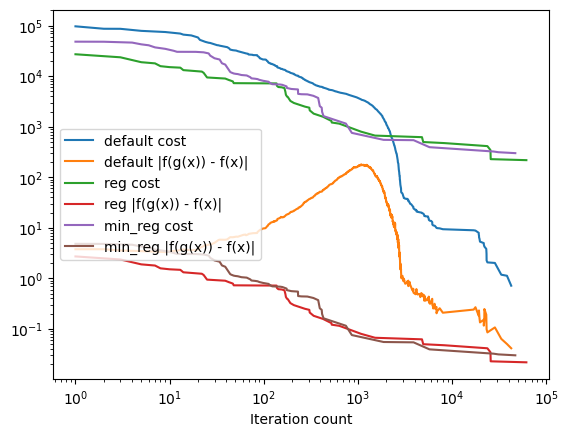

In [4]:
rng = np.random.default_rng(seed=1234)
input = create_training_data(n=10_000, scale=10.0, rng=rng)

cost_functions = [
    Default(function_under_test["prod"], [MRCandidate.from_identity()]),
    Reg(function_under_test["prod"], [MRCandidate.from_identity()], alpha=1e-5),
    MinReg(function_under_test["prod"], [MRCandidate.from_identity()], alpha=1e-5),    
]

for c_func in cost_functions:
    optimizer = Optimizer(c_func, input, rng=rng)
    %time mr = optimizer.optimize(mut_scale=MUT_SCALE, timeout=100_000)
    plot_convergence(optimizer)

## Test dependence on regularization constant $\alpha$

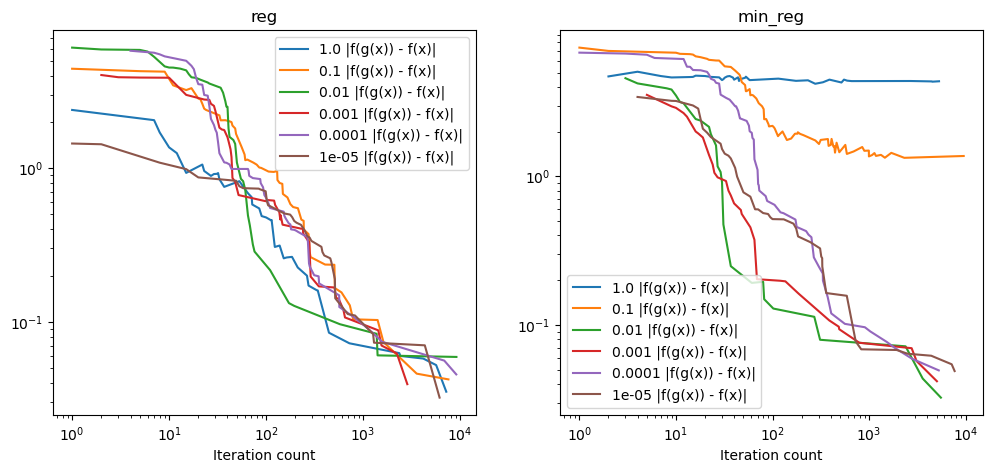

In [5]:
plt.figure(figsize=(12, 5))
for i, c_func_class in enumerate([Reg, MinReg]):
    plt.subplot(1, 2, i+1)
    plt.title(c_func_class.name)
    for alpha in [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
        c_func = c_func_class(function_under_test["prod"], [MRCandidate.from_identity()], alpha=alpha)
        optimizer = Optimizer(c_func, input, rng=rng)
        mr = optimizer.optimize(mut_scale=MUT_SCALE, timeout=10_000)
        plot_convergence(optimizer, label=alpha, cost=False)    

# Conclusion
- The cost function `default` is not able to optimize the mean distance between the results of the function under test of the morphed and original input.
- Both proposed cost functions, `reg` and `min_reg`, are able to optimize for the mean distance. However, their ability depends on the new hyperparameter $\alpha$.
- For this function under test and input data scale, a good choice for $\alpha$ seems to be `1e-2` and smaller.
- The value of $\alpha$ depends on the scale of the regularization term compared to the mean distance and the strength of the desired regularization.

# Repeating experiment with function under test `sum` 

CPU times: user 57 s, sys: 1.19 s, total: 58.2 s
Wall time: 58.3 s
CPU times: user 1min 7s, sys: 1.67 s, total: 1min 9s
Wall time: 1min 9s
CPU times: user 1min 8s, sys: 1.85 s, total: 1min 10s
Wall time: 1min 10s


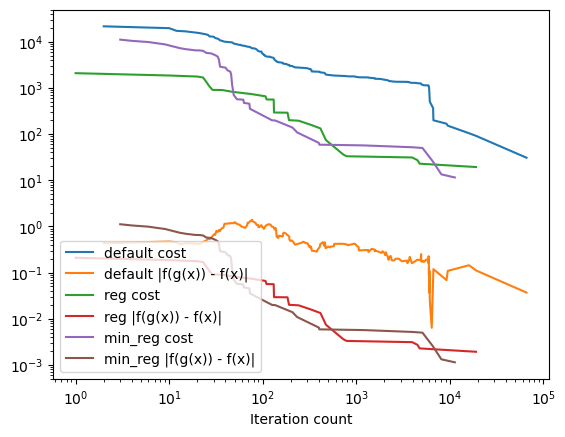

In [6]:
cost_functions = [
    Default(function_under_test["sum"], [MRCandidate.from_identity()]),
    Reg(function_under_test["sum"], [MRCandidate.from_identity()], alpha=1e-5),
    MinReg(function_under_test["sum"], [MRCandidate.from_identity()], alpha=1e-5),    
]

for c_func in cost_functions:
    optimizer = Optimizer(c_func, input, rng=rng)
    %time mr = optimizer.optimize(mut_scale=MUT_SCALE, timeout=100_000)
    plot_convergence(optimizer)

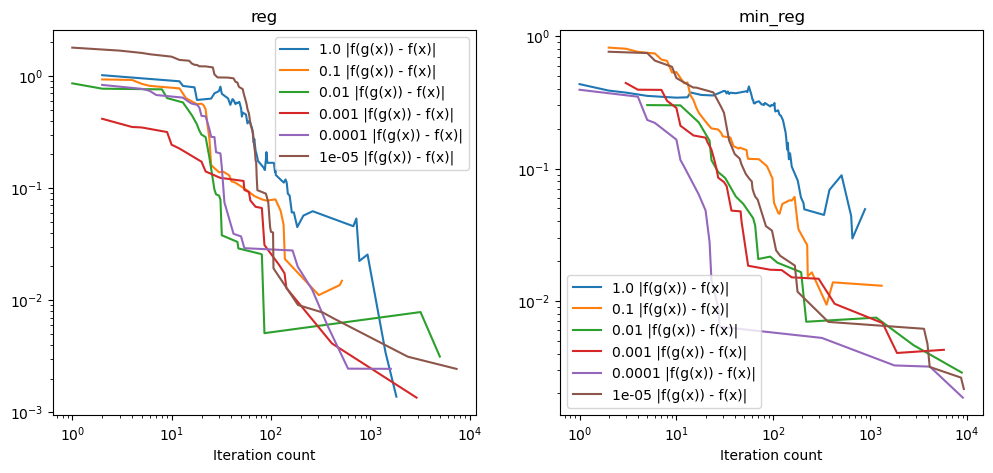

In [7]:
plt.figure(figsize=(12, 5))
for i, c_func_class in enumerate([Reg, MinReg]):
    plt.subplot(1, 2, i+1)
    plt.title(c_func_class.name)
    for alpha in [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
        c_func = c_func_class(function_under_test["sum"], [MRCandidate.from_identity()], alpha=alpha)
        optimizer = Optimizer(c_func, input, rng=rng)
        mr = optimizer.optimize(mut_scale=MUT_SCALE, timeout=10_000)
        plot_convergence(optimizer, label=alpha, cost=False)    